In [4]:

import os
from TTS.utils.audio import AudioProcessor
from TTS.utils.io import save_model
from TTS.config import load_config
from TTS.tts.models.tacotron2 import Tacotron2
from TTS.tts.utils.text.symbols import symbols, phonemes
from TTS.trainer import Trainer, TainingArgs
from TTS.tts.datasets import load_train_eval_items
from TTS.utils.trainer_utils import global_prune, will_prune
from TTS.tts.models import setup_model as setup_tts_model
import torch
import numpy as np
from matplotlib import pyplot as plt
from TTS.tts.utils.visual import plot_spectrogram, plot_alignment
import json
import re

from IPython.display import Audio
%matplotlib inline



BASE_DIR = '/home/perry/PycharmProjects/TTS/recipes/ljspeech/prune/tacotron2_nomask/'
ZERO_DIR = BASE_DIR + 'baseline/'
ZERO_FILE = ZERO_DIR + "checkpoint_100000.pth.tar"
CONFIG_PATH = ZERO_DIR + "config.json"
DATA_DIR = "/home/perry/PycharmProjects/TTS/recipes/ljspeech/LJSpeech-1.1/"

In [2]:
plt.style.use('dark_background')

In [10]:
def check_sparsity(config_path, model_file):
    config = load_config(config_path)
    model = setup_tts_model(config)
    model.load_checkpoint(config, model_file, eval=True)
    model = model.cuda()
    total_elems = 0
    total_nonzeros = 0
    for name, param in model.named_parameters():
        elems = param.numel()
        total_elems += elems
        nonzeros =  param.count_nonzero().item()
        total_nonzeros += nonzeros
        print(name, elems, nonzeros)
    print(f'Total elems: {total_elems}, total nonzeros: {total_nonzeros}')


In [11]:
config = load_config(CONFIG_PATH)
model = setup_tts_model(config)
sparsity_dir = BASE_DIR + 'snip/sparsity_40_stop_batch/'
model_file = sparsity_dir + 'best_model.pth.tar'
for name, param in model.named_parameters():
    elems = param.numel()
check_sparsity(CONFIG_PATH, model_file)

 > Using model: tacotron2
 > Model's reduction rate `r` is set to: 1
embedding.weight 102400 20699
encoder.convolutions.0.convolution1d.weight 1310720 1094922
encoder.convolutions.0.convolution1d.bias 512 0
encoder.convolutions.0.batch_normalization.weight 512 512
encoder.convolutions.0.batch_normalization.bias 512 512
encoder.convolutions.1.convolution1d.weight 1310720 1120251
encoder.convolutions.1.convolution1d.bias 512 0
encoder.convolutions.1.batch_normalization.weight 512 512
encoder.convolutions.1.batch_normalization.bias 512 512
encoder.convolutions.2.convolution1d.weight 1310720 1146717
encoder.convolutions.2.convolution1d.bias 512 0
encoder.convolutions.2.batch_normalization.weight 512 512
encoder.convolutions.2.batch_normalization.bias 512 512
encoder.lstm.weight_ih_l0 524288 509067
encoder.lstm.weight_hh_l0 262144 222395
encoder.lstm.bias_ih_l0 1024 1011
encoder.lstm.bias_hh_l0 1024 1013
encoder.lstm.weight_ih_l0_reverse 524288 502096
encoder.lstm.weight_hh_l0_reverse 26214

In [3]:
def test_prune(config_path, model_file, prune_amount, exclude_params=(),
               test_dir='phoneme_ids', test_files=('LJ022-0006.npy', 'LJ010-0002.npy')):
    C = load_config(config_path)
    ap = AudioProcessor(**C.audio)
    model = setup_tts_model(C)
    model.load_checkpoint(C, model_file, eval=True)
    model = model.cuda()
    alignments = []
    spectrograms = []
    global_prune(model, prune_amount, exclude_params)

    for test_file in test_files:
        char_ids = np.load(os.path.join(DATA_DIR, test_dir, test_file))
        if C.enable_eos_bos:
            char_ids = [2] + char_ids.tolist() + [1]
            char_ids = [2] + char_ids + [1]
            char_ids = np.asarray(char_ids)
        char_ids = torch.tensor(char_ids).unsqueeze(0)
        char_ids = char_ids.cuda()

        results = model.inference(char_ids)
        model_output = results['model_outputs']
        alignment = results['alignments'].cpu().numpy().squeeze()
        alignments.append(alignment)
        spectrogram = model_output.cpu().numpy().squeeze().T
        spectrograms.append(spectrogram)

        mel_length = spectrogram.shape[-1]
        mel_gt_length = np.load(os.path.join(DATA_DIR, 'mel', test_file)).shape[-1]
        print(f'output: {mel_length}, ground truth: {mel_gt_length}')

        wav = ap.inv_melspectrogram(spectrogram)
        wav_path = os.path.join(os.path.dirname(MODEL_FILE), test_file.replace('npy', 'wav'))
        ap.save_wav(wav, wav_path)

    return C, model, alignments, spectrograms


# Do not remove the stopnet
# Use new scheduler but continue with loaded optimizer to stabilize initial gradients
# Both using old scheduler / new optimizer lead to exploding gradients


In [10]:
sparsity_dir = 'snip/sparsity_40_stop_batch/'
prune_amount = float(re.sub(r'sparsity_(\d+).*', r'\1', sparsity_dir)) / 100

MODEL_DIR = BASE_DIR + sparsity_dir
prune_json = MODEL_DIR + 'prune_config.json'
with open(prune_json) as f:
    prune_config = json.load(f)
    exclude_params = prune_config['exclude_params']

MODEL_FILE = MODEL_DIR + 'best_model.pth.tar'

C, model, alignments, spectrograms = test_prune(CONFIG_PATH, MODEL_FILE, prune_amount=prune_amount, exclude_params=exclude_params)

 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20.0
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60.0
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Using model: tacotron2
 > Model's reduction rate `r` is set to: 1
Total trainable params: 46994338
Total params eligible to prune: 46991728
 > Model pruned by 60.0%
   > Decoder stopped with `max_decoder_steps` 1000
output: 1000, ground truth: 593
   > Decoder stopped with `max_decoder_steps` 1000
output: 1000, ground 

In [6]:
prune_amount

0.6

In [5]:
def check_prune_params(model_dir, model=None):
    C = load_config(model_dir + 'config.json')
    if model is None:
        model = setup_tts_model(C)
    prune_json = model_dir + 'prune_config.json'
    with open(prune_json) as f:
        prune_config = json.load(f)
    exclude_params = prune_config['exclude_params']
    param_sizes = {p: tensor.numel() for p, tensor in model.named_parameters() if tensor.requires_grad}
    print('Total trainable params: {}'.format(sum(param_sizes.values())))
    prune_params = [p for p in param_sizes.keys() if will_prune(exclude_params, p)]
    print('Total params eligible to prune: {}'.format(sum(param_sizes[p] for p in prune_params)))
    prune_params = set(prune_params)
    print('Exclusions:')
    for p, tensor in model.named_parameters():
        if p not in prune_params:
            print('\t' + p)
        else:
            print(p, tensor.numel(), int(tensor.count_nonzero()))
    return prune_params


In [6]:
# C, model, alignments, spectrograms = test_prune(CONFIG_PATH, MODEL_FILE, prune_amount=prune_amount, exclude_params=exclude_params)
sparsity_dir = 'sparsity_60_os0.5_stop/'
prune_amount = float(re.sub(r'sparsity_(\d+).*', r'\1', sparsity_dir)) / 100

MODEL_DIR = BASE_DIR + sparsity_dir
prune_json = MODEL_DIR + 'prune_config.json'
C = load_config(CONFIG_PATH)
MODEL_FILE = MODEL_DIR + 'epoch_1.pth.tar'
model = setup_tts_model(C)
model.load_checkpoint(C, MODEL_FILE, eval=True)
prune_params = check_prune_params(BASE_DIR + 'sparsity_60_os0.5_stop/', model)

 > Using model: tacotron2
 > Model's reduction rate `r` is set to: 1
Total trainable params: 46994338
Total params eligible to prune: 46991728
Exclusions:
embedding.weight 102400 100445
encoder.convolutions.0.convolution1d.weight 1310720 1310720
encoder.convolutions.0.convolution1d.bias 512 512
encoder.convolutions.0.batch_normalization.weight 512 512
encoder.convolutions.0.batch_normalization.bias 512 512
encoder.convolutions.1.convolution1d.weight 1310720 1310720
encoder.convolutions.1.convolution1d.bias 512 512
encoder.convolutions.1.batch_normalization.weight 512 512
encoder.convolutions.1.batch_normalization.bias 512 512
encoder.convolutions.2.convolution1d.weight 1310720 1310720
encoder.convolutions.2.convolution1d.bias 512 512
encoder.convolutions.2.batch_normalization.weight 512 512
encoder.convolutions.2.batch_normalization.bias 512 512
encoder.lstm.weight_ih_l0 524288 524288
encoder.lstm.weight_hh_l0 262144 262144
encoder.lstm.bias_ih_l0 1024 1024
encoder.lstm.bias_hh_l0 1024

In [35]:
sparsity_dir = 'sparsity_60_os0.5_embed_stop/'
prune_amount = float(re.sub(r'sparsity_(\d+).*', r'\1', sparsity_dir)) / 100

MODEL_DIR = BASE_DIR + sparsity_dir
prune_json = MODEL_DIR + 'prune_config.json'
with open(prune_json) as f:
    prune_config = json.load(f)
    exclude_params = prune_config['exclude_params']

MODEL_FILE = MODEL_DIR + 'epoch_1.pth.tar'

C, model, alignments, spectrograms = test_prune(CONFIG_PATH, MODEL_FILE, prune_amount=prune_amount, exclude_params=exclude_params)


 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20.0
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60.0
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Using model: tacotron2
 > Model's reduction rate `r` is set to: 1
Total trainable params: 46994338
Total params eligible to prune: 46889328
 > Model pruned by 60.0%
   > Decoder stopped with `max_decoder_steps` 1000
output: 1000, ground truth: 593
   > Decoder stopped with `max_decoder_steps` 1000
output: 1000, ground 

In [36]:
prune_params = check_prune_params(BASE_DIR + 'sparsity_60_os0.5_embed_stop/', model)

Total trainable params: 46994338
Total params eligible to prune: 46889328
Exclusions:
	embedding.weight
encoder.convolutions.0.convolution1d.weight 1310720 213935
encoder.convolutions.0.convolution1d.bias 512 0
encoder.convolutions.0.batch_normalization.weight 512 512
encoder.convolutions.0.batch_normalization.bias 512 512
encoder.convolutions.1.convolution1d.weight 1310720 209836
encoder.convolutions.1.convolution1d.bias 512 0
encoder.convolutions.1.batch_normalization.weight 512 512
encoder.convolutions.1.batch_normalization.bias 512 512
encoder.convolutions.2.convolution1d.weight 1310720 206632
encoder.convolutions.2.convolution1d.bias 512 0
encoder.convolutions.2.batch_normalization.weight 512 512
encoder.convolutions.2.batch_normalization.bias 512 512
encoder.lstm.weight_ih_l0 524288 314031
encoder.lstm.weight_hh_l0 262144 168515
encoder.lstm.bias_ih_l0 1024 658
encoder.lstm.bias_hh_l0 1024 634
encoder.lstm.weight_ih_l0_reverse 524288 317686
encoder.lstm.weight_hh_l0_reverse 26214

In [ ]:
prune_params = [p.rsplit('.', 1) for p in prune_params]
from TTS.utils.trainer_utils import get_module_by_name
prune_params = [(get_module_by_name(model, access_string), param) for access_string, param in prune_params]

In [24]:

spec = np.load('/home/perry/PycharmProjects/TTS/recipes/ljspeech/prune/coqui_tts-20220204_1907-aa986857/sparsity_80_s0.5/full_mel_100000/LJ022-0006.npy')
ap = AudioProcessor(**C.audio)
wav = ap.inv_melspectrogram(spec)
wav_path = os.path.join('/tmp/LJ022-0006.wav')
ap.save_wav(wav, wav_path)

 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20.0
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60.0
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024


In [39]:
prune_before = {}
prune_after = {}
for p, tensor in model.named_parameters():
    prune_before[p] = tensor.numel()
    prune_after[p] = int(tensor.count_nonzero())


In [40]:
for p in prune_before.keys():
    print(p, prune_before[p], prune_after[p])

embedding.weight 102400 101888
encoder.convolutions.0.convolution1d.weight 1310720 213959
encoder.convolutions.0.convolution1d.bias 512 0
encoder.convolutions.0.batch_normalization.weight 512 512
encoder.convolutions.0.batch_normalization.bias 512 512
encoder.convolutions.1.convolution1d.weight 1310720 209864
encoder.convolutions.1.convolution1d.bias 512 0
encoder.convolutions.1.batch_normalization.weight 512 512
encoder.convolutions.1.batch_normalization.bias 512 512
encoder.convolutions.2.convolution1d.weight 1310720 206644
encoder.convolutions.2.convolution1d.bias 512 0
encoder.convolutions.2.batch_normalization.weight 512 512
encoder.convolutions.2.batch_normalization.bias 512 512
encoder.lstm.weight_ih_l0 524288 314038
encoder.lstm.weight_hh_l0 262144 168520
encoder.lstm.bias_ih_l0 1024 658
encoder.lstm.bias_hh_l0 1024 634
encoder.lstm.weight_ih_l0_reverse 524288 317687
encoder.lstm.weight_hh_l0_reverse 262144 167785
encoder.lstm.bias_ih_l0_reverse 1024 666
encoder.lstm.bias_hh_l0

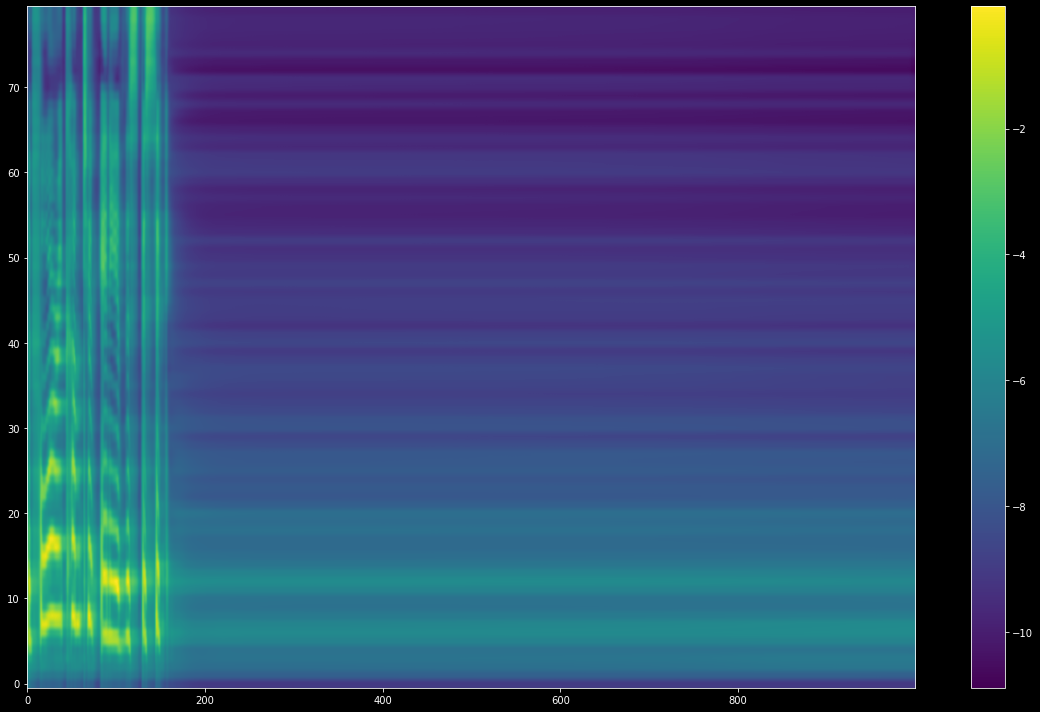

In [7]:
plot_spectrogram(spectrograms[0].T)

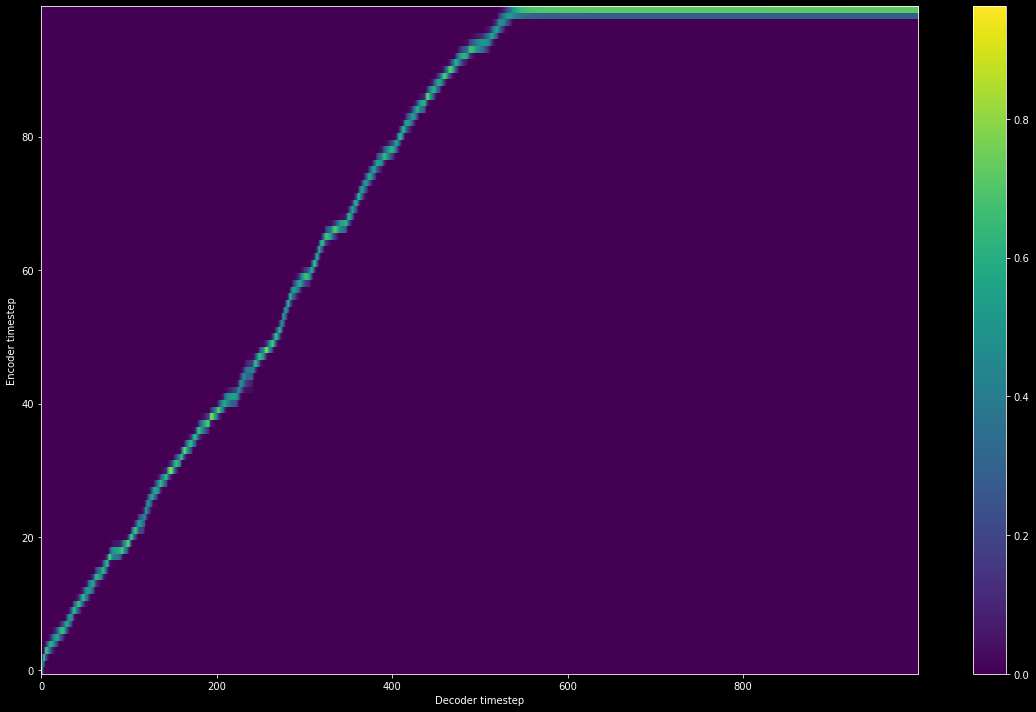

In [11]:
plot_alignment(alignments[0])